In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import gc
import random
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from tqdm.notebook import tqdm
import yaml

from deepinvhessian import fwi
import warnings
warnings.filterwarnings('ignore')

In [5]:
# https://github.com/swag-kaust/Transform2022_SelfSupervisedDenoising/blob/main/tutorial_utils.py
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    
    Parameters
    ----------
    seed: int 
        Integer to be used for the seed
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    return True

set_seed(14)

True

In [6]:
# https://stackoverflow.com/questions/48152674/how-do-i-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [12]:
# Define the model and acquisition parameters

par = {

        # model parameters
        'nx':500,   'dx':5.,        'ox':0,
        'nz':251,   'dz':5.,        'oz':0,
        'nr':250,   'dr':10,       'orec':0,  'rz':0,
        'ns':25,    'ds':100,       'osou':50,  'sz':0,
        'nt':500,   'dt':0.004,     'ot':0,

        # Inversion parameters
        'FWI_itr': 100, 'num_dims':2,
        'batch_size':1,
        'fwi_pass': 1,   # This is a count in case the code stopped and you want to resume 
        'freq' : 5,       # Dominant frequency


       # Input files 
        'vel_true': '../data/SEAM_Vp_Elastic_N23900_chop.bin',
   
         

#         # others parameters 
        'vel_true_path':'',


    }



num_sources_per_shot=1    
fs = 1/par['dt'] # sampling frequency

 
par ['num_batches'] = par['ns']//par ['batch_size'] 


# declare all the par in local variables
for k in par:
    locals()[k] = par[k]


exp_name = 'Exp-FWI'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

# Save the parametrs of this experiment (P.S. I save the parameter in the vel_path which is the main output)
with open(f'{exp_name}/parameters.yml', 'w') as outfile:
    yaml.dump(par, outfile, default_flow_style=False)

In [13]:
# ----------------------- input files ---------------------------------

Fvel =  par['vel_true_path'] +   par['vel_true']
    
# Load the true model
model_true = (np.fromfile(Fvel, np.float32).reshape(nx, nz))
model_true = np.transpose(model_true)

Text(0.5, 1.0, 'True Model')

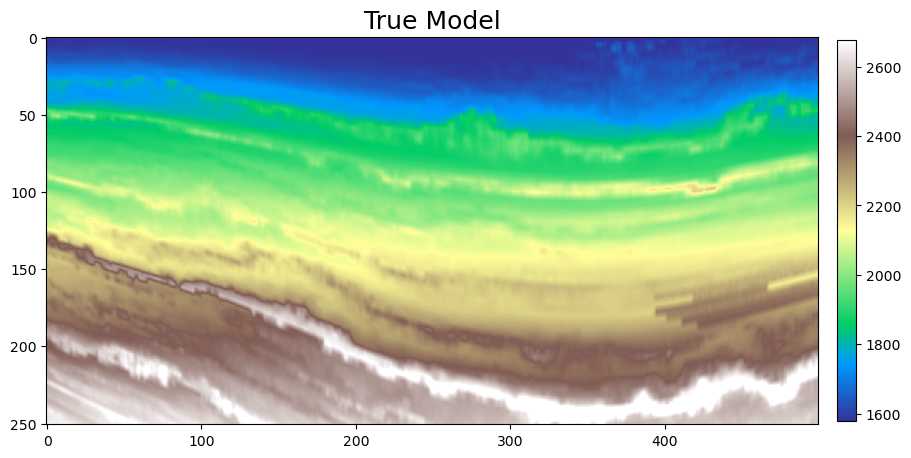

In [14]:
plt.figure(figsize=(12,8))
dm_vmin, dm_vmax = np.percentile(model_true, [2,98])
plt.imshow(model_true, vmin=dm_vmin, vmax=dm_vmax, cmap='terrain')
plt.colorbar(shrink=0.62, pad=0.02)
plt.title('True Model', fontsize=18)

In [18]:
model_true = torch.tensor(model_true, dtype=torch.float32)

# initiate the fwi class
inversion = fwi.FWI(par,1)
# Create the source wavelet
wavel = inversion.ricker(freq).repeat(1,ns,1)
# compute the true data
data_true = inversion.forward_modelling(model_true, wavel, device).cpu()
torch.cuda.empty_cache()

Text(0, 0.5, 'Time (ms)')

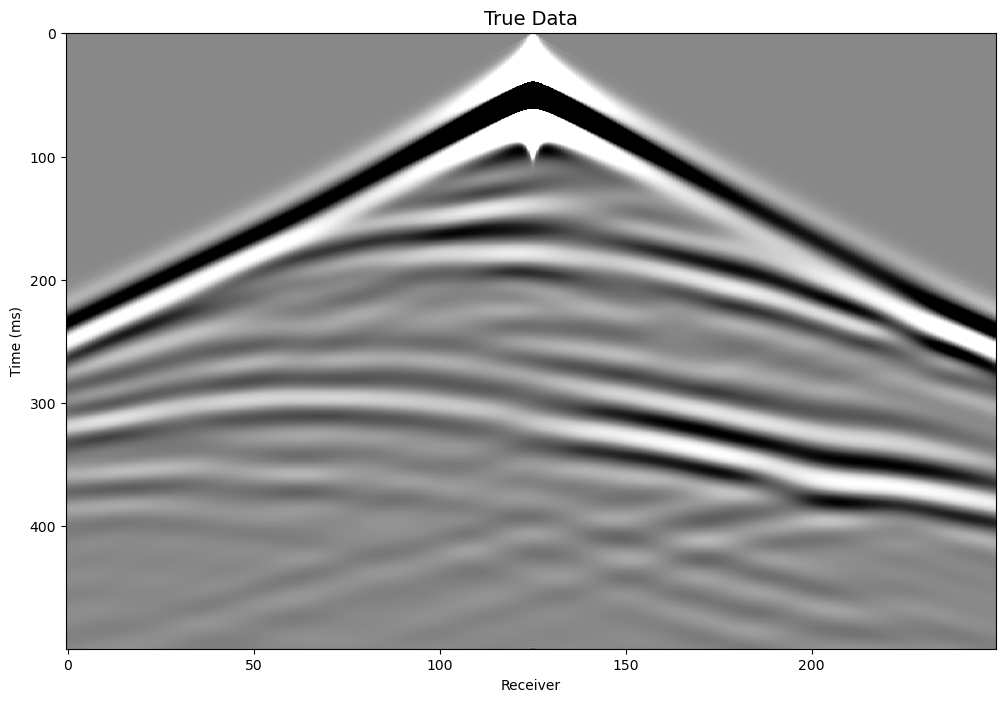

In [19]:
data_true = data_true.detach()
plt.figure(figsize=(12,8))
vmin, vmax = np.percentile(data_true[:, 12], [2,98])
plt.imshow(data_true[:, 12], aspect='auto', vmin=vmin, vmax=vmax, cmap= 'Greys')
plt.title('True Data', fontsize=14)
plt.xlabel('Receiver')
plt.ylabel('Time (ms)')

In [20]:
# Create initial guess model for inversion by smoothing the true model
model_init = gaussian_filter(model_true.cpu().detach(), sigma=15)
model_init = torch.tensor(model_init)
# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone().to(device)
model.requires_grad = True

msk = torch.ones_like(model)
msk[:20] = 0
msk = msk.to(device)

In [21]:
#  inversion
update, loss, vel_loss, gradients = inversion.run_inversion(model, model_true.to(device), data_true, wavel, 
                                                            msk, FWI_itr, device)

Iteration: 0 Objective: 1.1411731833277372e-05
Iteration: 1 Objective: 9.566962589246941e-06
Iteration: 2 Objective: 8.208753584426631e-06
Iteration: 3 Objective: 7.171926597493439e-06
Iteration: 4 Objective: 6.355400017810098e-06
Iteration: 5 Objective: 5.696966326240727e-06
Iteration: 6 Objective: 5.156638351877518e-06
Iteration: 7 Objective: 4.707480940169262e-06
Iteration: 8 Objective: 4.330223447368553e-06
Iteration: 9 Objective: 4.010619420569128e-06
Iteration: 10 Objective: 3.7377852777353837e-06
Iteration: 11 Objective: 3.502177108316573e-06
Iteration: 12 Objective: 3.298915977723027e-06
Iteration: 13 Objective: 3.1218632869922658e-06
Iteration: 14 Objective: 2.9666988439203124e-06
Iteration: 15 Objective: 2.8299963901190495e-06
Iteration: 16 Objective: 2.70893243481396e-06
Iteration: 17 Objective: 2.6011585987362196e-06
Iteration: 18 Objective: 2.504828856331187e-06
Iteration: 19 Objective: 2.4183011575473756e-06
Iteration: 20 Objective: 2.3402933528871017e-06
Iteration: 21 Ob

Text(0.5, 0, 'WE solved')

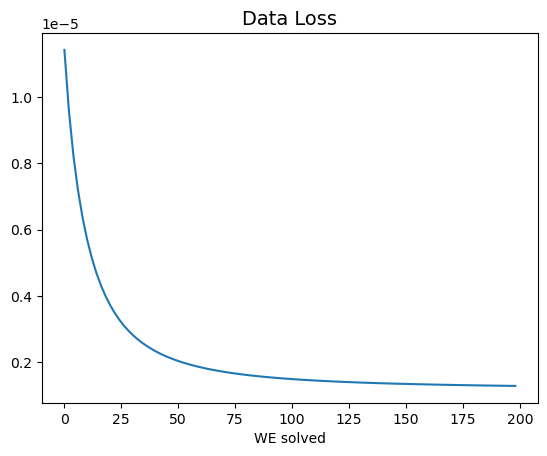

In [22]:
# Plot the data loss per number of wave equation solved 
plt.plot(np.arange(0, 200, 2), loss)
plt.title('Data Loss', fontsize=14)
plt.xlabel('WE solved')

Text(0.5, 0, 'WE solved')

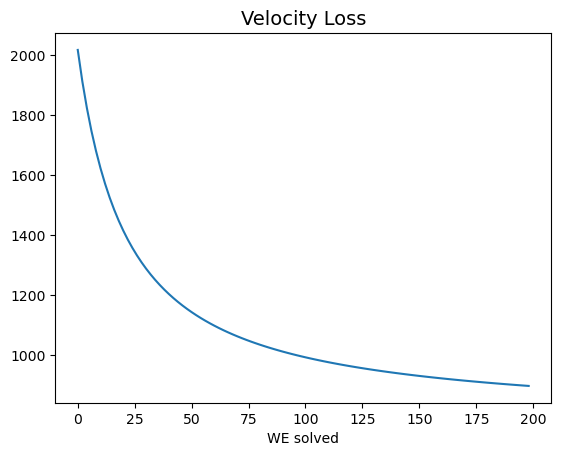

In [23]:
# Plot the velocity loss per number of wave equation solved 
plt.plot(np.arange(0, 200, 2), vel_loss)
plt.title('Velocity Loss', fontsize=14)
plt.xlabel('WE solved')

In [25]:
np.savez(f'{exp_name}/results', data_loss=np.array(loss),
                                vel_loss=np.array(vel_loss))
np.savez(f'{exp_name}/results2', updates=np.array(update),
                                 gradients=np.array(gradients))